# Online Courses Recommender Systems

Adrian P. Bustamante, Ph.D. \
adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#1.-Objective">Objective</a></li>
    <li><a href="#2.-About-the-data">About the data</a></li>
    <li><a href="#3.-EDA">Exploratory Data Analysis (EDA)</a></li>
    <li><a href="#4.-Feature-Engineering">Feature Engineering</a></li>
    <li><a href="#5.-Recommender-Systems">Recommender-Systems</a></li>
    <ol>
        <li><a href="#A.-Content-based-Course-Recommender-System-Using-User-Profile-and-Course-Genres">Content based Course Recommender System Using User Profile and Course Genres</a></li>
        <li><a href="#B.-Content-based-Course-Recommender-System-using-Course-Similarities" >Content based Course Recommender System using Course Similarities</a></li>
        <li><a href="#C.-Clustering-based-Course-Recommender-System-using-PCA-and-KMeans" >Clustering based Course Recommender System using PCA and KMeans</a></li>
        <li><a href="#D.-Collaborative-Filtering-based-Recommender-System-using-Nearest-Neighbors" >Collaborative Filtering based Recommender System using Nearest Neighbors</a></li>
    </ol>
    <li><a href="#6.-Conclusion">Conclusion</a></li>
</ol>

## 1. Objective

We consider data about online courses and user interations with the courses. The objective of this notebook is to create a small survey of recommender systems to understand the main ideas behind contert-base filtering and collaborative filtering.

This work is based on the Machine Learning Capstone Project at https://www.coursera.org/learn/machine-learning-capstone?specialization=ibm-machine-learning

###### Importing libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim, nltk, scipy, random, sklearn
import tensorflow as tf
import tensorflow.keras as keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora


%matplotlib inline
plt.style.use('dark_background')
rs = 666 #random state

2025-03-28 16:36:31.842939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 16:36:31.843172: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 16:36:31.845973: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 16:36:31.875435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 16:36:32.476108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## 2. About the data

###### Downloading the data

In [2]:
import pandas as pd 

course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"

course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)
course_content_df = pd.read_csv(course_url)
course_df.shape, ratings_df.shape, course_content_df.shape

((307, 16), (233306, 3), (307, 3))

###### Course_df contains the courses id's, names and the genres of the courses in sparse matrix form

In [3]:
course_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


###### ratings_df contains user id's , courses taken, and the rating given to each course taken.

The **rating** column consists of three potential values: 

- A rating of <code>5</code> signifies that users who have enrolled in the course find it excellent and have given it the highest rating, thus recommending it to other learners. 

- A rating of <code>4</code>, indicates that the enrolled users perceive the course as good and will recommend to the other learners,but suggest minor improvements. 

- A rating of <code>3</code>indicates that enrolled users find the course below expectations and need significant modifications.


In [4]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


###### course_content_df contains course id, title of the course, and a description of the course.

In [5]:
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


## 3. EDA

###### non-null values, dtypes

In [6]:
course_df.info(), ratings_df.info(), course_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   COURSE_ID        307 non-null    object
 1   TITLE            307 non-null    object
 2   Database         307 non-null    int64 
 3   Python           307 non-null    int64 
 4   CloudComputing   307 non-null    int64 
 5   DataAnalysis     307 non-null    int64 
 6   Containers       307 non-null    int64 
 7   MachineLearning  307 non-null    int64 
 8   ComputerVision   307 non-null    int64 
 9   DataScience      307 non-null    int64 
 10  BigData          307 non-null    int64 
 11  Chatbot          307 non-null    int64 
 12  R                307 non-null    int64 
 13  BackendDev       307 non-null    int64 
 14  FrontendDev      307 non-null    int64 
 15  Blockchain       307 non-null    int64 
dtypes: int64(14), object(2)
memory usage: 38.5+ KB
<class 'pandas.core.frame.DataFra

(None, None, None)

#### Ploting Word Cloud from Course Titles

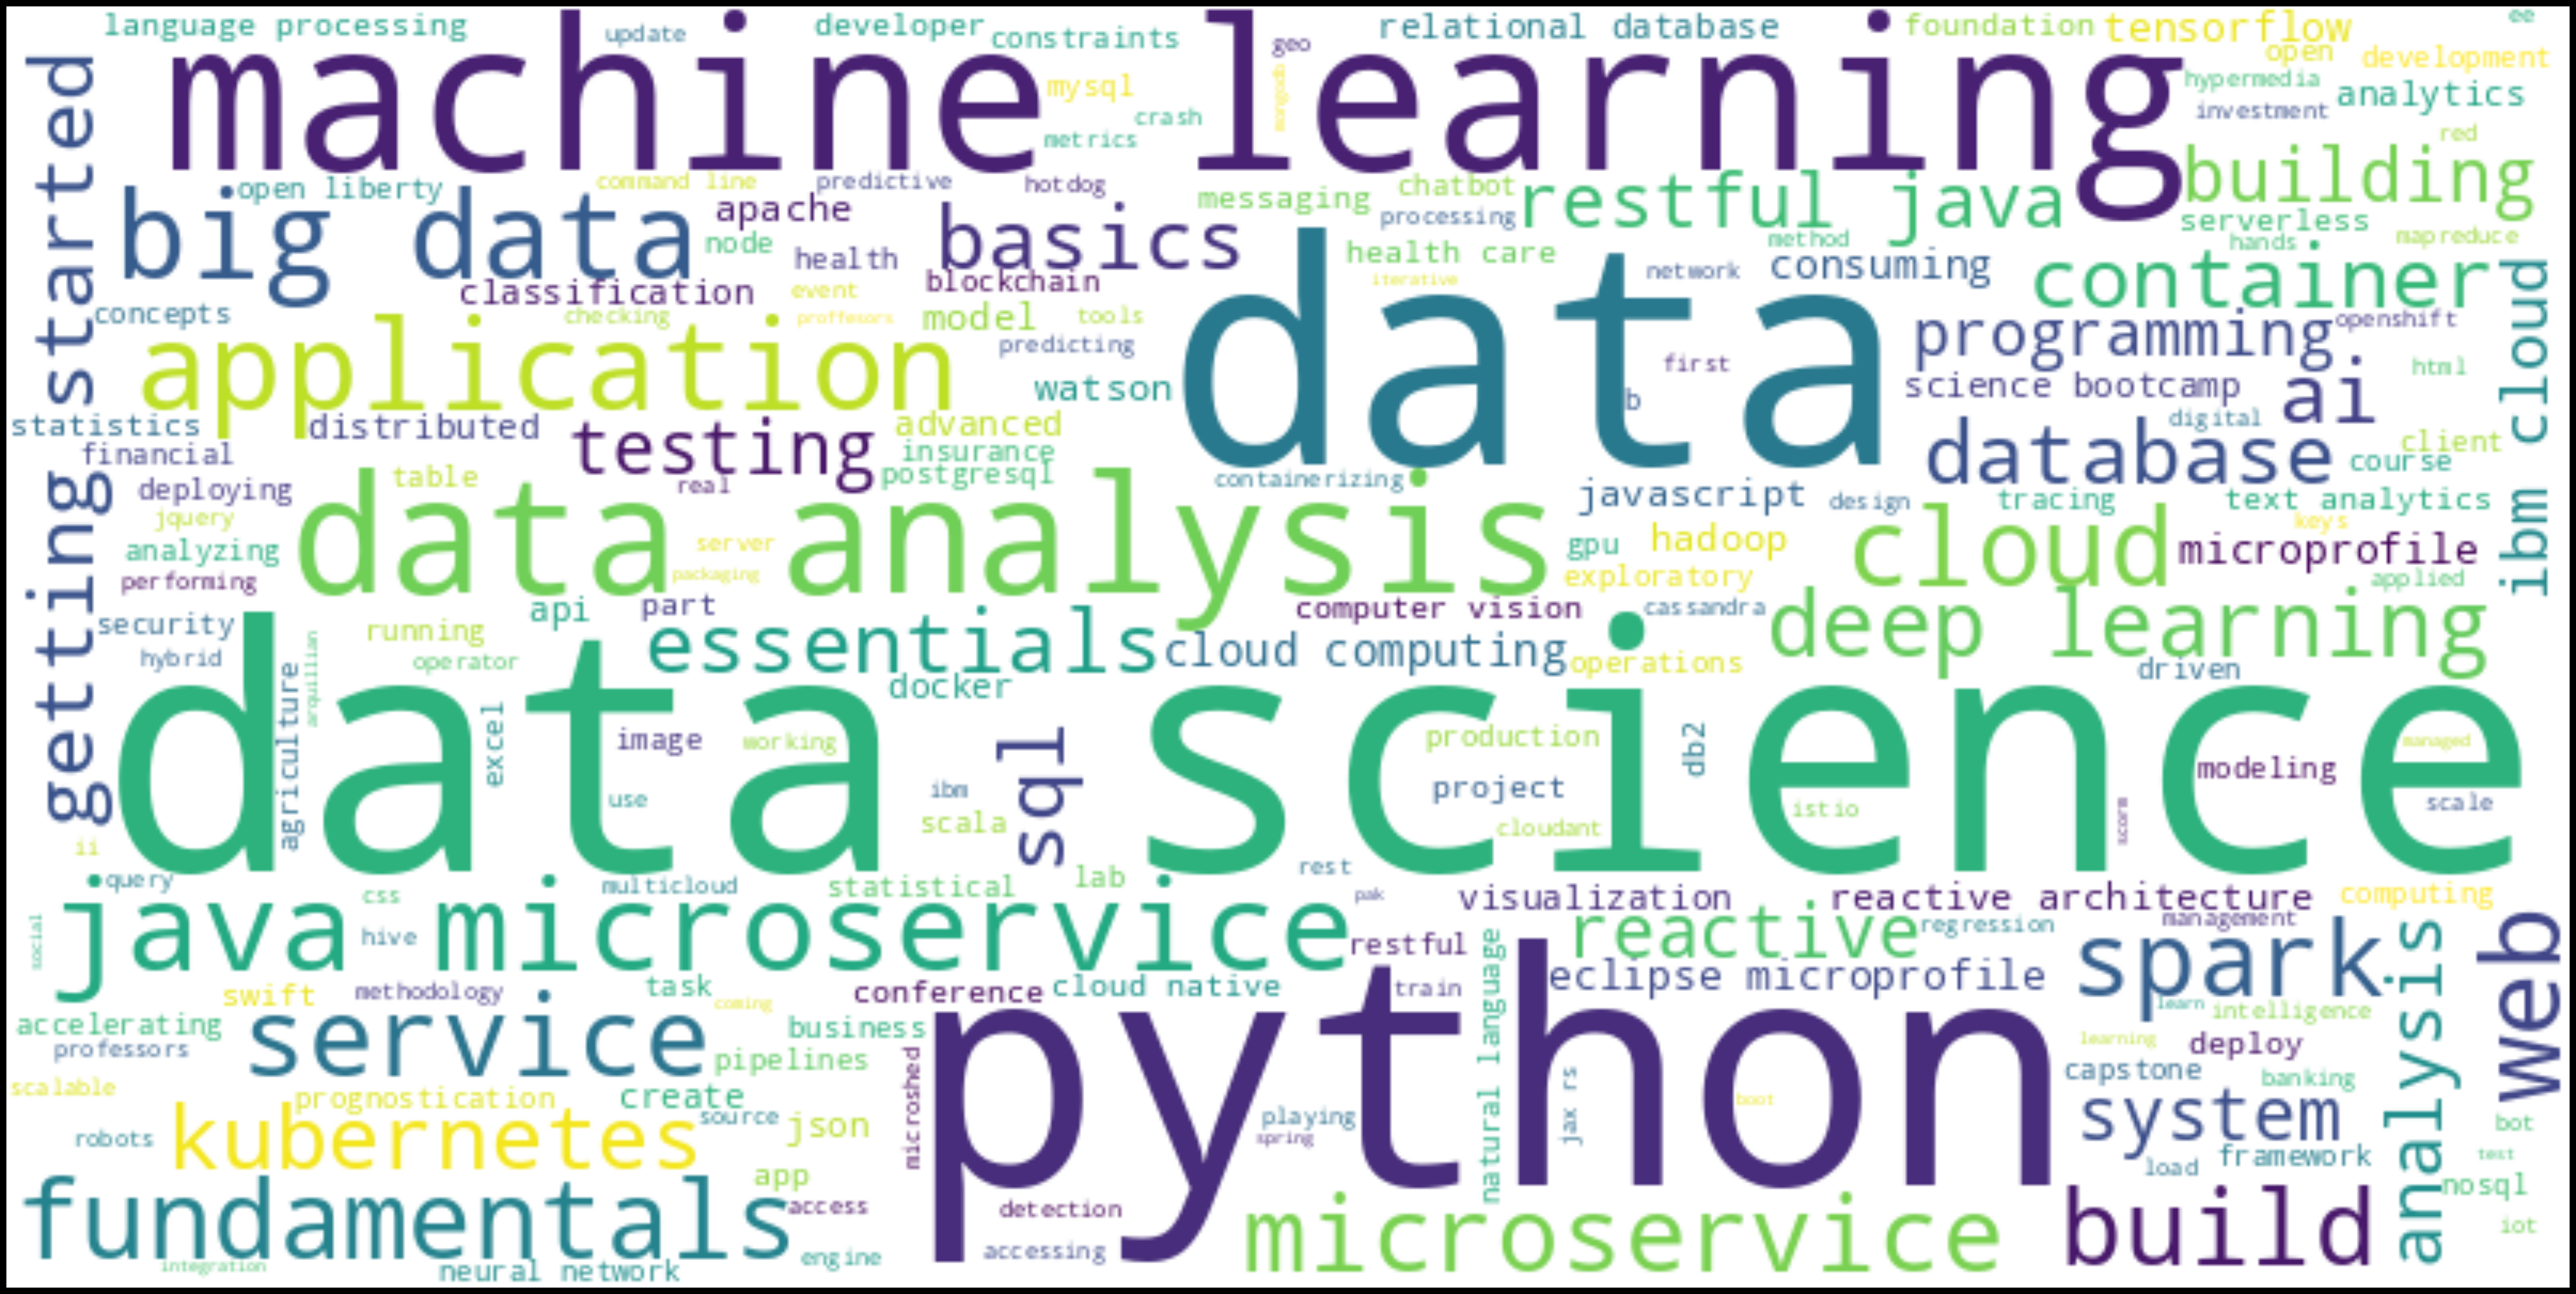

In [7]:
titles = " ".join(title for title in course_df['TITLE'].astype(str))
# English Stopwords
stopwords = set(STOPWORDS)
stopwords.update(["getting started", "using", "enabling", "template", "university", "end", "introduction", "basic"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400)
wordcloud.generate(titles)

plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

As we can see from the ```wordcloud```,  there are many popular IT related keywords such as python, data science, machine learning, big data, ai, tensorflow, container, cloud, etc. By looking at these keywords, we should have a general understanding that the courses in the dataset are focused on demanding IT skills.


#### Course genres

In [8]:
###Courses belonging to the machine learning genre
course_df[course_df['MachineLearning'] == 1]

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
15,DAI101EN,data ai essentials,0,0,0,0,0,1,0,0,0,0,0,0,0,0
19,HCC105EN,ybrid cloud conference ai pipelines lab,0,0,0,0,0,1,0,0,0,0,0,0,0,0
21,DS0132EN,data ai jumpstart your journey,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24,BENTEST4,ai for everyone master the basics,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,excourse61,convolutional neural networks in tensorflow,0,0,0,0,0,1,1,0,0,0,0,0,0,0
282,excourse69,machine learning with big data,0,0,0,0,0,1,0,0,1,0,0,0,0,0
290,excourse77,natural language processing with attention models,0,0,0,0,0,1,0,0,0,0,0,0,0,0
291,excourse78,natural language processing with sequence models,0,0,0,0,0,1,0,0,0,0,0,0,0,0


###### Genres distribution

<Axes: xlabel='Count', ylabel='None'>

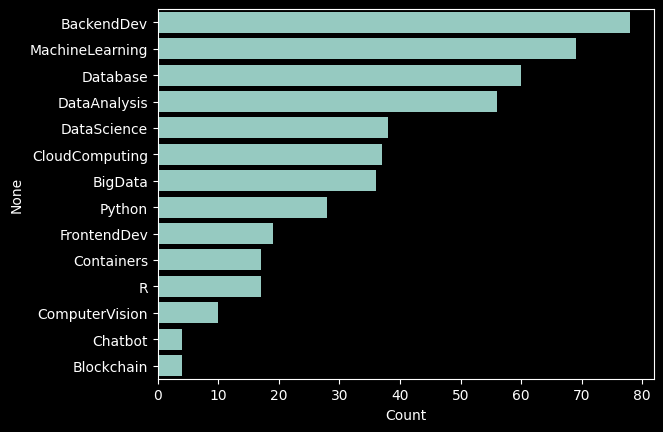

In [9]:
genres = course_df.columns[2:]
genre_sums = pd.DataFrame(course_df[genres].sum(axis=0), columns=['Count']).sort_values(by='Count', ascending=False)
sns.barplot(y=genre_sums.index, x='Count', data=genre_sums, orient='h')

#### Course Enrollments

In [10]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [11]:
print('enrollments: ', len(ratings_df))
##only three possible ratings
ratings_df['rating'].unique()

enrollments:  233306


array([5, 3, 4])

In [12]:
## a user can be enrolled in many courses
ratings_df[ratings_df['user']==2]

,user,item,rating
5402,2,LB0105ENv1,3
5602,2,ST0101EN,3
6827,2,PY0101EN,3
7172,2,ML0120ENv2,3
11109,2,DA0101EN,5
...,...,...,...
196742,2,DJ0101EN,5
200325,2,RP0103EN,4
208467,2,ML0122EN,4
209385,2,LB0103ENv1,3


In [13]:
user_enrollment = pd.DataFrame(ratings_df.groupby('user').size(), columns=['enrolls']).reset_index()
user_enrollment

,user,enrolls
0,2,61
1,4,44
2,5,59
3,7,1
4,8,3
...,...,...
33896,2102054,8
33897,2102356,1
33898,2102680,11
33899,2102983,1


###### Enrollment distribution

Text(0, 0.5, 'users')

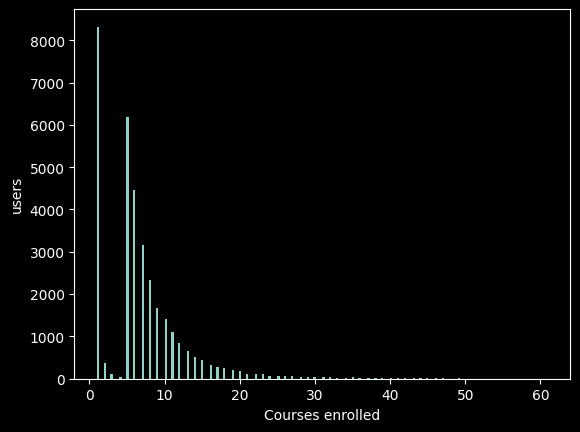

In [14]:
ax=plt.gca()
user_enrollment['enrolls'].hist(bins=200, grid=False, ax=ax)
ax.set_xlabel('Courses enrolled')
ax.set_ylabel('users')

##### Top 20 most popular courses

In [15]:
top_courses = ratings_df.groupby('item').size().reset_index().rename(columns={'item':'course', 0:'Ratings'})
top_courses = top_courses.sort_values(by='Ratings', ascending=False).reset_index(drop=True)
merged_top_title = top_courses.merge(course_df[['COURSE_ID', 'TITLE']],
                  how='left',
                  left_on='course',
                  right_on='COURSE_ID')
merged_top_title[['COURSE_ID','TITLE', 'Ratings']].head(20)

,COURSE_ID,TITLE,Ratings
0,PY0101EN,python for data science,14936
1,DS0101EN,introduction to data science,14477
2,BD0101EN,big data 101,13291
3,BD0111EN,hadoop 101,10599
4,DA0101EN,data analysis with python,8303
5,DS0103EN,data science methodology,7719
6,ML0101ENv3,machine learning with python,7644
7,BD0211EN,spark fundamentals i,7551
8,DS0105EN,data science hands on with open source tools,7199
9,BC0101EN,blockchain essentials,6719


## 4. Feature Engineering

#### Extract Bag of Words (BoW) Features from Course Content

The main goal of recommender systems is to help users find items they potentially interested in. Depending on the recommendation tasks, an item can be a movie, a restaurant, or, in our case, an online course. 

Machine learning algorithms cannot work on an item directly so we first need to extract features and represent the items mathematically, i.e., with a feature vector.

Many items are often described by text so they are associated with textual data, such as the titles and descriptions of a movie or course. Since machine learning algorithms can not process textual data directly, we need to transform the raw text into numeric feature vectors.

###### Course Content

In [16]:
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


In [17]:
# Merge TITLE and DESCRIPTION 
course_content_df['course_texts'] = course_content_df[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)
course_content_df

,COURSE_ID,TITLE,DESCRIPTION,course_texts
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...,robots are coming build iot apps with watson ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...,accelerating deep learning with gpu training c...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...,consuming restful services using the reactive ...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...,analyzing big data in r using apache spark apa...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...,containerizing packaging and running a sprin...
...,...,...,...,...
302,excourse89,javascript jquery and json,in this course we ll look at the javascript l...,javascript jquery and json in this course w...
303,excourse90,programming foundations with javascript html ...,learn foundational programming concepts e g ...,programming foundations with javascript html ...
304,excourse91,front end web development with react,this course explores javascript based front en...,front end web development with react this cour...
305,excourse92,introduction to web development,this course is designed to start you on a path...,introduction to web development this course is...


###### Tokenizing courses

In [18]:
###Natural Language Toolkit (nltk)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/adrian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [19]:
##tokenizes one course
def tokenize_course(course, keep_only_nouns=True):
    # Get English stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # Tokenize the course text
    word_tokens = word_tokenize(course)
    # Remove English stop words and numbers
    word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
    # Only keep nouns
    if keep_only_nouns:
        # Define a filter list of non-noun POS (Part of Speech) tags
        filter_list = ['WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS',
                       'RP']
        # Tag the word tokens with POS tags
        tags = nltk.pos_tag(word_tokens)
        # Filter out non-nouns based on POS tags
        word_tokens = [word for word, pos in tags if pos not in filter_list]

    return word_tokens

In [20]:
a_course = course_content_df.iloc[0, :]['course_texts']
a_course

'robots are coming  build iot apps with watson  swift  and node red have fun with iot and learn along the way  if you re a swift developer and want to learn more about iot and watson ai services in the cloud  raspberry pi   and node red  you ve found the right place  you ll build iot apps to read temperature data  take pictures with a raspcam  use ai to recognize the objects in those pictures  and program an irobot create 2 robot  '

In [21]:
#nltk.corpus.stopwords.words('english')
tokenize_course(a_course)

['robots',
 'coming',
 'build',
 'iot',
 'apps',
 'watson',
 'swift',
 'red',
 'fun',
 'iot',
 'learn',
 'way',
 'swift',
 'developer',
 'want',
 'learn',
 'iot',
 'watson',
 'ai',
 'services',
 'cloud',
 'raspberry',
 'pi',
 'node',
 'red',
 'found',
 'place',
 'build',
 'iot',
 'apps',
 'read',
 'temperature',
 'data',
 'take',
 'pictures',
 'raspcam',
 'use',
 'ai',
 'recognize',
 'objects',
 'pictures',
 'program',
 'irobot',
 'create',
 'robot']

In [22]:
### tokenizing all courses in data frame
def tokenize_courses_from_df(data=course_content_df):
    return [ tokenize_course(course) for course in data['course_texts'] ]

tokenized_courses = tokenize_courses_from_df()

###### token dictionary

In [23]:
tokens_dict = gensim.corpora.Dictionary(tokenized_courses)

###### BoW features for each tokenized course

In [24]:
courses_bow = [tokens_dict.doc2bow(course) for course in tokenized_courses]
courses_bow[3]

[(6, 4),
 (63, 1),
 (77, 1),
 (83, 1),
 (117, 1),
 (118, 1),
 (119, 1),
 (120, 2),
 (121, 1),
 (122, 1),
 (123, 1),
 (124, 1),
 (125, 1),
 (126, 1),
 (127, 1),
 (128, 1),
 (129, 1),
 (130, 1),
 (131, 1),
 (132, 2),
 (133, 1),
 (134, 2),
 (135, 1),
 (136, 1),
 (137, 1),
 (138, 1),
 (139, 1)]

###### BoW DataFrame

In [25]:
course_indices =[]
course_ids = []
tokens =[]
bow_values = []

for course_index, course_bow in enumerate(courses_bow):
    for token_index, token_bow in course_bow:
        course_indices.append(course_index)
        course_ids.append(course_content_df.loc[course_index,'COURSE_ID'])
        tokens.append(tokens_dict.get(token_index))
        bow_values.append(token_bow)

bow_dicts = {'course_index': course_indices,
             'course_id':course_ids,
             'token':tokens,
             'bow':bow_values}

bow_df = pd.DataFrame(bow_dicts)
bow_df

,course_index,course_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1
...,...,...,...,...
10358,306,excourse93,modifying,1
10359,306,excourse93,objectives,1
10360,306,excourse93,pieces,1
10361,306,excourse93,plugins,1


###### course id to index and index to id dictionaries

In [26]:
def get_doc_dicts(bow_df=bow_df):
    # Group the DataFrame by course index and ID, and get the maximum value for each group
    grouped_df = bow_df.groupby(['course_index', 'course_id']).max().reset_index(drop=False)
    # Create a dictionary mapping indices to course IDs
    idx_id_dict = grouped_df[['course_id']].to_dict()['course_id']
    # Create a dictionary mapping course IDs to indices
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    # Clean up temporary DataFrame
    del grouped_df
    return idx_id_dict, id_idx_dict

idx_id_dict, id_idx_dict = get_doc_dicts()

#### Courses Similarity using BoW

Similarity measurement between items is the foundation of many recommendation algorithms, especially for content-based recommendation algorithms. For example, if a new course is similar to user's enrolled courses, we could recommend that new similar course to the user. Or If user A is similar to user B, then we can recommend some of user B's courses to user A (the unseen courses) because user A and user B may have similar interests.

###### Example with two courses using cosine similarity (i.e., $sim(a,b) = 1-\cos(a,b)$)

In [27]:
###bow given course id ='ML0101ENv3'
ml_course = bow_df[bow_df['course_id'] == 'ML0101ENv3']
ml_course

,course_index,course_id,token,bow
2747,158,ML0101ENv3,course,1
2748,158,ML0101ENv3,learning,4
2749,158,ML0101ENv3,machine,3
2750,158,ML0101ENv3,need,1
2751,158,ML0101ENv3,get,1
2752,158,ML0101ENv3,started,1
2753,158,ML0101ENv3,python,2
2754,158,ML0101ENv3,tool,1
2755,158,ML0101ENv3,tools,1
2756,158,ML0101ENv3,predict,1


In [28]:
ml_course.pivot(index=['course_id'],columns='token', values='bow').reset_index(level=[0])

token,course_id,beneficial,course,free,future,get,give,hidden,insights,learning,machine,need,predict,python,started,supervised,tool,tools,trends,unsupervised
0,ML0101ENv3,1,1,1,1,1,1,1,1,4,3,1,1,2,1,1,1,1,1,1


In [29]:
def pivot_two_bows(basedoc, comparedoc):
    """
    Pivot two bag-of-words (BoW) representations for comparison.

    Parameters:
    basedoc (DataFrame): DataFrame containing the bag-of-words representation for the base document.
    comparedoc (DataFrame): DataFrame containing the bag-of-words representation for the document to compare.

    Returns:
    DataFrame: A DataFrame with pivoted BoW representations for the base and compared documents,
    facilitating direct comparison of word occurrences between the two documents.
    """

    # Create copies of the input DataFrames to avoid modifying the originals
    base = basedoc.copy()
    base['doc_type'] = 'base'  # Add a 'type' column indicating base document
    compare = comparedoc.copy()
    compare['doc_type'] = 'compare'  # Add a 'type' column indicating compared document

    # Concatenate the two DataFrames vertically
    join = pd.concat([base, compare])

    # Pivot the concatenated DataFrame based on 'doc_id' and 'type', with words as columns
    joinT = join.pivot(index=['course_id', 'doc_type'], columns='token', values='bow').fillna(0).reset_index(level=[0, 1])

    # Return the pivoted DataFrame for comparison
    return joinT

In [30]:
course1 = bow_df[bow_df['course_id'] == 'ML0151EN']
course2 = bow_df[bow_df['course_id'] == 'BD0153EN']
bow_vectors = pivot_two_bows(course1, course2)
bow_vectors

token,course_id,doc_type,ability,able,analyst,analyze,analyzing,approachable,basics,big,...,statistical,stored,student,supervised,type,ui,unsupervised,using,visualize,vs
0,BD0153EN,compare,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
1,ML0151EN,base,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [31]:
similarity = 1- scipy.spatial.distance.cosine(bow_vectors.iloc[0,2:], bow_vectors.iloc[1,2:])
similarity

0.06440081861116376

###### Courses similarity matrix

In [32]:
### courses ids
course_ids = list(bow_df['course_id'].unique())

sim_mat_courses = np.zeros((len(course_ids), len(course_ids)) )
for i, base_id in enumerate(course_ids):
    for j, compare_id in zip( range(i,len(course_ids)), course_ids[i:] ):
        course1 = bow_df[bow_df['course_id'] == base_id]
        course2 = bow_df[bow_df['course_id'] == compare_id]
        bow_vects = pivot_two_bows(course1, course2)
        sim_mat_courses[i,j]=1-scipy.spatial.distance.cosine(bow_vects.iloc[0,2:], bow_vects.iloc[1,2:])

sim_mat_courses = np.where(sim_mat_courses, sim_mat_courses, sim_mat_courses.T)
sim_mat_courses = pd.DataFrame(data=sim_mat_courses, columns=course_ids, index=course_ids)

In [33]:
sim_mat_courses

,ML0201EN,ML0122EN,GPXX0ZG0EN,RP0105EN,GPXX0Z2PEN,CNSC02EN,DX0106EN,GPXX0FTCEN,RAVSCTEST1,GPXX06RFEN,...,excourse84,excourse85,excourse86,excourse87,excourse88,excourse89,excourse90,excourse91,excourse92,excourse93
ML0201EN,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.073278,0.039276,0.121113
ML0122EN,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138990,0.031367,0.076940
GPXX0ZG0EN,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.134095,0.012684,0.000000
RP0105EN,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017534,0.018796,0.158073
GPXX0Z2PEN,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.130548,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
excourse89,0.033944,0.028239,0.018270,0.094759,0.060474,0.064851,0.053856,0.039467,0.036539,0.060474,...,0.047186,0.116008,0.137406,0.211743,0.256220,1.000000,0.211520,0.169473,0.129766,0.263734
excourse90,0.076825,0.063911,0.082698,0.030638,0.030415,0.000000,0.000000,0.119098,0.055132,0.045622,...,0.177989,0.092381,0.145126,0.527636,0.249675,0.211520,1.000000,0.243531,0.416067,0.178384
excourse91,0.073278,0.138990,0.134095,0.017534,0.130548,0.009333,0.000000,0.255599,0.094656,0.026110,...,0.153927,0.105739,0.139415,0.282573,0.133670,0.169473,0.243531,1.000000,0.221307,0.129574
excourse92,0.039276,0.031367,0.012684,0.018796,0.000000,0.015008,0.024926,0.082199,0.076102,0.055978,...,0.149234,0.093962,0.162170,0.476644,0.222350,0.129766,0.416067,0.221307,1.000000,0.126274


###### Finding similar courses

In [34]:
def similar_courses(course_id = 'ML0101ENv3', sim_matrix= sim_mat_courses, threshold = 0.3):
    '''Courses similar to the give course
    
    Parameters:
    course_id (str): Selected course
    sim_matrix (DataFrame): Similarity matrix between all courses
    threshold (float): Defines criteria to select similar courses

    Return:
    DataFrame: a dataframe of courses ids and similarity with the couses whose similarity with 
    'course_id' is larger than 'thresthold'. Returns the top 20 courses, at most.
    DataFrame is void is there are not similar courses in the selected threshold.
    '''
    sim_vect = sim_matrix[course_id].sort_values(ascending=False)[1:]
    sim_vect = pd.DataFrame(sim_vect[ sim_vect.values > threshold]).reset_index()
    sim_vect.rename(columns = {'index':'course_id', course_id: 'Similarity'}, inplace=True)
    return sim_vect.head(10)

In [35]:
a = random.choice(course_ids)
print('Chosen course: ', course_content_df[course_content_df['COURSE_ID']==a]['TITLE'].values)
print('Similar courses: ')
for i in similar_courses(a)['course_id'].values:
    print(course_content_df[course_content_df['COURSE_ID']==i]['TITLE'].values)

Chosen course:  ['programming for everybody  getting started with python ']
Similar courses: 
['python basics']
['crash course on python']
['using databases with python']
['introduction to python programming']
['introduction to data science in python']
['introduction to data science in python']
['python for data science']
['python scripting  files  inheritance  and databases']
['python programming  a concise introduction']
['docker  basics']


## 5. Recommender Systems

### A. Content based Course Recommender System Using User Profile and Course Genres

The most common type of content-based recommendation system is to recommend items to users based on their profiles. The user's profile revolves around that user's preferences and tastes. It is shaped based on user ratings, including the number of times a user has clicked on different items or liked those items.

The recommendation process is based on the similarity between those items. The similarity or closeness of items is measured based on the similarity in the content of those items. When we say content, we're talking about things like the item's category, tag, genre, and so on. Essentially the features about an item.

For online course recommender systems, we already know how to extract features from courses (such as genres or BoW features). Next, based on the course genres and users' ratings, we want to further build user profiles (if unknown).

A user profile can be seen as the user feature vector that quantifies a user's learning interests.

With the user profile feature vectors and course genre feature vectors constructed, we can use several computational methods, such as a simple dot product, to compute or predict an interest score for each course and recommend those courses with high interest scores.


##### Generate user profiles using course genres and ratings

###### Generating user profile for one user

To compute the user profile, $u_i$, for user $i$ we consider the courses user $i$ has taken. We store the ratings in the vector $v_i\in \mathbb{R}^{1\times r_i}$ (user $i$ has rated/taken $r_i$ courses). For each course taken by user $i$ we consider the features of each course, we store courses genres in a sparse matrix $M_i\in \mathbb{R}^{r_i\times 14}$ (we only have 14 genres, see course_df). Finally, we compute $u_i$ as follows $$ u_i = v_i M_i \in\mathbb{R}^{1\times 14}.$$
$u_i$ quantifies the interest of user $i$, based on the ratings the user has provided.

###### example

In [36]:
user_id=779563
user_rc = ratings_df[ratings_df['user']==user_id][['rating', 'item']].values
user_rc

array([[3, 'DS0101EN'],
       [5, 'ST0101EN'],
       [5, 'BC0101EN'],
       [3, 'BD0101EN'],
       [3, 'DA0101EN'],
       [4, 'PY0101EN'],
       [4, 'DV0101EN']], dtype=object)

In [37]:
genres_user = course_df[course_df['COURSE_ID'].isin(user_rc[:,1])].iloc[:, 2:]
genres_user

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
81,0,0,0,0,0,0,0,0,0,0,0,1,0,1
106,0,0,0,1,0,0,0,0,0,0,0,0,0,0
147,1,0,0,0,0,0,0,0,1,0,0,0,0,0
161,0,1,0,1,0,0,0,0,0,0,0,0,0,0
176,0,0,0,0,0,0,0,1,0,0,0,0,0,0
188,0,1,0,0,0,0,0,1,0,0,0,0,0,0
198,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [38]:
user_profile = pd.concat([pd.DataFrame(data=[user_id], columns=['user']),
                          pd.DataFrame(data= np.matmul(user_rc[:,0], np.array(genres_user)),
                          index=course_df.columns[2:]).T.astype(float)], axis=1)
user_profile

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,779563,5.0,11.0,0.0,12.0,0.0,0.0,0.0,7.0,5.0,0.0,0.0,3.0,0.0,3.0


##### Users profile matrix

In [39]:
user_ids =np.sort(ratings_df['user'].unique())
profiles = np.zeros((len(user_ids),14))

for i,user_id in enumerate(user_ids):
    user_rc = ratings_df[ratings_df['user']==user_id][['rating', 'item']].values
    genres_user = course_df[course_df['COURSE_ID'].isin(user_rc[:,1])].iloc[:, 2:]
    profiles[i] = np.matmul(user_rc[:,0], np.array(genres_user))

del user_rc
del genres_user 

profiles = pd.concat([pd.DataFrame(data=user_ids, columns=['user']),
                      pd.DataFrame(data=profiles, columns=course_df.columns[2:]).astype(float)],
                     axis=1)    

In [40]:
profiles

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,74.0,21.0,8.0,66.0,5.0,50.0,0.0,40.0,62.0,3.0,22.0,44.0,10.0,7.0
1,4,81.0,4.0,8.0,57.0,0.0,29.0,0.0,41.0,49.0,0.0,11.0,9.0,0.0,3.0
2,5,47.0,16.0,37.0,50.0,0.0,58.0,0.0,41.0,31.0,4.0,27.0,49.0,7.0,10.0
3,7,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,8,13.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,13.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,2102054,5.0,4.0,5.0,7.0,0.0,0.0,0.0,9.0,0.0,0.0,8.0,7.0,0.0,4.0
33897,2102356,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33898,2102680,4.0,10.0,8.0,0.0,0.0,21.0,0.0,14.0,0.0,0.0,3.0,0.0,0.0,0.0
33899,2102983,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Recommendations scores per user

To compute recommendation scores for user $i$ we consider the matrix storing the genres of the courses that user $i$ has not seen/taken, denote it by $A_i\in \mathbb{R}^{s_i \times 14}$. The recommendation scores for user $i$, then, are given be $$A_i u_i^\top \in\mathbb{R}^{s_i\times 1}$$ where $u_i$ is user's $i$ profile vector. The recommended courses will be the ones with the largest scores.

In [41]:
def generate_recommendation_scores(user_id =1078030):
    """
    Generate recommendation scores for users and courses.

    Parameters:
    user_id (int): User id 
    Returns:
    courses (list): List of recommended course IDs.
    scores (list): List of recommendation scores.
    """

    courses = []    # List to store recommended course IDs
    scores = []     # List to store recommendation scores

    user_profile = profiles[profiles['user']==user_id]
    ###get the courses user have not seen 
    user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
    user_unseen_courses_id = list(set(course_ids).difference(user_courses))
    user_unseen_courses = course_df[course_df['COURSE_ID'].isin(user_unseen_courses_id)].iloc[:,2:].values

    ##recommendation scores
    recommendation_scores = np.matmul(user_unseen_courses, user_profile.iloc[0,1:].values)
    for i in range(len(user_unseen_courses_id)):
        courses.append(user_unseen_courses_id[i])
        scores.append(recommendation_scores[i])
    
    return courses, scores
 

##### Recommendations

In [42]:
user_id = random.choice(user_ids)

##user courses
print(f'User {user_id} has taken the following courses:')
user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
for course in user_courses:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

###user recommendations
courses, scores = generate_recommendation_scores(user_id)
res_dict = {}
# Store the lists of users, courses, and scores into the res_dict dictionary with corresponding keys
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
# Create a DataFrame named res_df using the res_dict dictionary
res_df = pd.DataFrame(res_dict, columns=['COURSE_ID', 'SCORE'])
###top 15 values
top_scores = res_df.sort_values(by='SCORE', ascending=False).head(15)
suggested_courses = top_scores['COURSE_ID'].values
print('--------------------')
print('Recommended Courses')
for course in suggested_courses:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)


User 1466266 has taken the following courses:
['reactive architecture  reactive microservices']
['reactive architecture  domain driven design']
['reactive architecture  building scalable systems']
['reactive architecture  distributed messaging patterns']
['reactive architecture  cqrs   event sourcing']
['reactive architecture  introduction to reactive systems']
--------------------
Recommended Courses
['building robots with tjbot']
['deploying a microservice to openshift by using a kubernetes operator']
['scala 101']
['medical appointment data analysis']
['consuming a restful java web service with reactjs']
['cloud computing basics  cloud 101 ']
['data science in agriculture  land use classification']
['db2 academic training']
['the nature of data and relational database design']
['build swift mobile apps with watson ai services']
['introduction to containers  kubernetes  and openshift v2']
['monitoring the metrics of java microservices using eclipse microprofile metrics']
['using r fo

### B. Content based Course Recommender System using Course Similarities

We use the course similarities matrix to recommend new courses which are similar to a user's presently enrolled courses.

##### Similarity matrix

In [43]:
sim_mat_courses.head()

,ML0201EN,ML0122EN,GPXX0ZG0EN,RP0105EN,GPXX0Z2PEN,CNSC02EN,DX0106EN,GPXX0FTCEN,RAVSCTEST1,GPXX06RFEN,...,excourse84,excourse85,excourse86,excourse87,excourse88,excourse89,excourse90,excourse91,excourse92,excourse93
ML0201EN,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.073278,0.039276,0.121113
ML0122EN,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138990,0.031367,0.076940
GPXX0ZG0EN,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.134095,0.012684,0.000000
RP0105EN,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017534,0.018796,0.158073
GPXX0Z2PEN,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.130548,0.000000,0.000000


<Axes: >

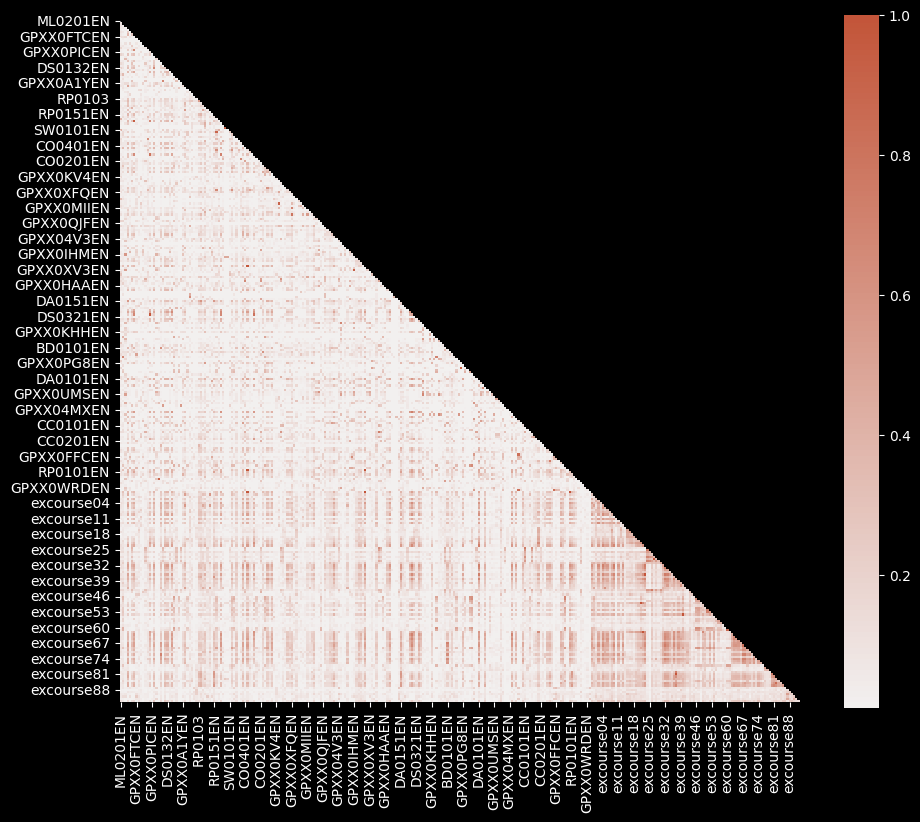

In [44]:
# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_mat_courses, dtype=bool))
# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))
# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_mat_courses, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0, square=True)

As we can see from the heatmap; there are many hot spots, which means many courses are similar to each other. Such patterns suggest that it is possible to build a recommender system based on course similarities. 


In [45]:
def generate_recommendations_with_sim_mat(user_id =2, sim_matrix = sim_mat_courses, threshold=0.5):
    '''
    Generate list of courses not taken with largest similarity scores agains the courses taken

    Parameters:
    user_id (int): User id
    sim_matrix (DataFrame): Similarity matrix of all courses
    threshold (float): Only courses with similarity > 'threshold' are considered
    Returns:
    res (pd.Series): Series with courses ids as index and similarites as values
    '''
    
    # Create a dictionary to store your recommendation results
    res = {}
    ##courses taken and not taken
    user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
    user_unseen_courses_id = list(set(course_ids).difference(user_courses))
    # Iterate over enrolled courses
    for enrolled_course in user_courses:
        # Iterate over unselected courses
        for unselect_course in user_unseen_courses_id:
            # Initialize similarity value
            sim = 0
            # Calculate the similarity between an enrolled_course and an unselect_course
            sim = sim_matrix.loc[enrolled_course,unselect_course]
            # Check if the similarity exceeds the threshold
            if sim > threshold:
                # Update recommendation dictionary with course ID and similarity score
                if unselect_course not in res:
                    # If the unselected course is not already in the recommendation dictionary (`res`), add it.
                    res[unselect_course] = sim
                else:
                    # If the unselected course is already in the recommendation dictionary (`res`), compare the similarity score.
                    # If the current similarity score is greater than or equal to the existing similarity score for the course,
                    # update the similarity score in the recommendation dictionary (`res`) with the current similarity score.
                    if sim >= res[unselect_course]:
                        res[unselect_course] = sim
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
     # Return the recommendation in a series
    return pd.Series(res)

##### Recommendations

In [46]:
user_id = random.choice(user_ids)

##user courses
print(f'User {user_id} has taken the following courses:')
user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
for course in user_courses:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

##recommended courses
print('--------------------')
print('Recommended Courses')
top_suggestions = generate_recommendations_with_sim_mat(user_id=user_id)
for course in top_suggestions.head(15).index:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

User 435338 has taken the following courses:
['hadoop 101']
--------------------
Recommended Courses
['controlling hadoop jobs using oozie']
['accessing hadoop data using hive']


### C. Clustering based Course Recommender System using PCA and KMeans

We can perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests.For each user group, we can come up with a list of popular courses. 

If we know a user belongs to a group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.

##### Scaling user profile matrix

In [47]:
profiles.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,74.0,21.0,8.0,66.0,5.0,50.0,0.0,40.0,62.0,3.0,22.0,44.0,10.0,7.0
1,4,81.0,4.0,8.0,57.0,0.0,29.0,0.0,41.0,49.0,0.0,11.0,9.0,0.0,3.0
2,5,47.0,16.0,37.0,50.0,0.0,58.0,0.0,41.0,31.0,4.0,27.0,49.0,7.0,10.0
3,7,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,8,13.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,13.0,0.0,3.0,0.0,0.0,0.0


In [48]:
feature_names = list(profiles.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

In [49]:
scaler = sklearn.preprocessing.StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
profiles_scaled = profiles.copy()
profiles_scaled[feature_names] = scaler.fit_transform(profiles[feature_names])
profiles_scaled


,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,6.513593,2.864496,0.916977,9.528615,1.153387,7.351735,-0.023772,4.707215,5.750720,1.494699,6.514577,7.070038,5.222156,2.105042
1,4,7.198288,-0.118105,0.916977,8.125928,-0.420308,3.984422,-0.023772,4.849404,4.406722,-0.436170,3.041307,1.029499,-0.230014,0.612521
2,5,3.872628,1.987260,6.475656,7.034949,-0.420308,8.634520,-0.023772,4.849404,2.545800,2.138321,8.093335,7.932973,3.586505,3.224433
3,7,-0.333352,-0.819893,-0.616452,-0.134343,-0.420308,-0.665676,-0.023772,-0.980345,-0.245581,-0.436170,-0.431962,-0.523783,-0.230014,-0.506870
4,8,0.546969,-0.819893,-0.616452,0.489073,-0.420308,-0.665676,-0.023772,-0.980345,0.684879,-0.436170,0.515294,-0.523783,-0.230014,-0.506870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,2102054,-0.235539,-0.118105,0.341941,0.333219,-0.420308,-0.665676,-0.023772,0.299356,-0.659119,-0.436170,2.094052,0.684325,-0.230014,0.985651
33897,2102356,-0.724606,-0.819893,-0.041416,-0.757760,-0.420308,-0.665676,-0.023772,-0.980345,-0.659119,-0.436170,-0.431962,-0.523783,-0.230014,-0.506870
33898,2102680,-0.333352,0.934578,0.916977,-0.757760,-0.420308,2.701636,-0.023772,1.010301,-0.659119,-0.436170,0.515294,-0.523783,-0.230014,-0.506870
33899,2102983,-0.724606,-0.819893,-0.616452,-0.757760,-0.420308,0.136065,-0.023772,-0.980345,-0.659119,-0.436170,-0.431962,-0.523783,-0.230014,-0.506870


In [50]:
profiles_scaled.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-2.179772e-17,7.608242e-17,-6.539315e-17,2.515121e-17,-3.143902e-17,3.521170e-17,1.425235e-17,-2.515121e-18,1.006049e-17,-1.341398e-17,-1.008144e-16,-8.383738e-19,9.850892e-18,-9.892811e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.246065e-01,-8.198934e-01,-6.164518e-01,-7.577599e-01,-4.203079e-01,-6.656761e-01,-2.377197e-02,-9.803454e-01,-6.591193e-01,-4.361697e-01,-4.319617e-01,-5.237831e-01,-2.300137e-01,-5.068699e-01
25%,6.813480e+05,-7.246065e-01,-8.198934e-01,-6.164518e-01,-7.577599e-01,-4.203079e-01,-6.656761e-01,-2.377197e-02,-9.803454e-01,-6.591193e-01,-4.361697e-01,-4.319617e-01,-5.237831e-01,-2.300137e-01,-5.068699e-01
50%,1.043907e+06,-3.333524e-01,-2.935521e-01,-6.164518e-01,-2.901974e-01,-4.203079e-01,-6.656761e-01,-2.377197e-02,-2.694004e-01,-3.489658e-01,-4.361697e-01,-4.319617e-01,-5.237831e-01,-2.300137e-01,-5.068699e-01
75%,1.451159e+06,3.513421e-01,5.836834e-01,3.419411e-01,4.890734e-01,-4.203079e-01,1.360649e-01,-2.377197e-02,5.837337e-01,3.747258e-01,-4.361697e-01,-4.319617e-01,1.665643e-01,-2.300137e-01,6.125210e-01
max,2.103039e+06,7.785169e+00,3.741731e+00,9.542513e+00,9.528615e+00,6.189209e+00,8.634520e+00,5.442849e+01,5.702538e+00,7.404872e+00,6.000058e+00,8.093335e+00,1.242023e+01,1.121954e+01,6.582606e+00


##### Using PCA on user profile feature vectors to reduce dimensions

If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:

In [90]:
###extracting matrix of features
features = profiles_scaled.iloc[:,1:]

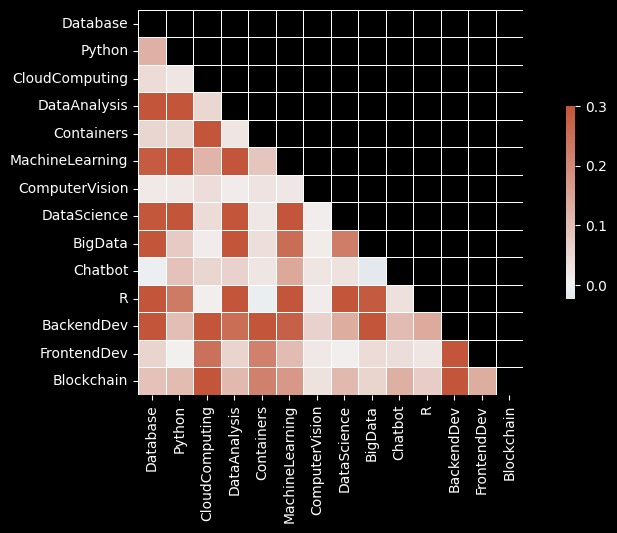

In [91]:
corr = features.cov()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 5))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [92]:
pca = sklearn.decomposition.PCA()
pca.fit(features)
pca.components_.shape, pca.n_components_

((14, 14), 14)

Text(0.5, 1.0, 'Cumulative explained variance ratio')

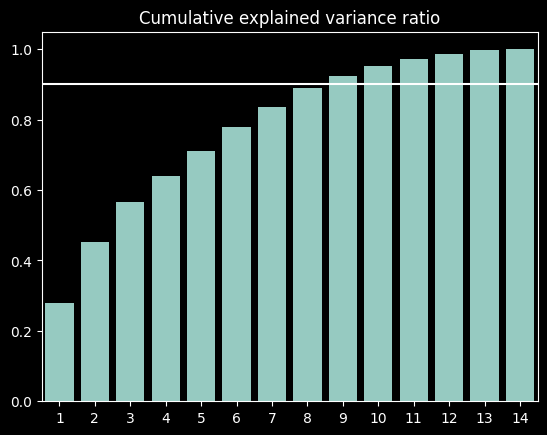

In [93]:
ax=plt.gca()
sns.barplot(x=range(1,15),y=np.cumsum(pca.explained_variance_ratio_), ax=ax).axhline(0.9)
ax.set_title('Cumulative explained variance ratio')

We can see above that using 9 components we can keep about 90% of the variances

In [55]:
pca = sklearn.decomposition.PCA(n_components=9)
pca.fit(features)
components = pca.transform(features)
components.shape, pca.components_.shape, pca.n_components_

((33901, 9), (9, 14), 9)

In [56]:
profiles_pca = pd.merge(left=profiles.loc[:, profiles.columns == 'user'], 
                        right=pd.DataFrame(data=components), 
                        left_index=True, 
                        right_index=True)
profiles_pca.rename(columns={i:f'PCA{i}' for i in range(10)},inplace=True)
profiles_pca

,user,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,2,18.686539,-0.381531,1.419599,2.386169,-2.586985,2.211857,-0.139238,1.435611,1.312180
1,4,11.736263,-4.275627,3.206473,-0.931196,0.556207,-0.706571,0.220027,0.530495,0.009949
2,5,17.280329,2.717895,-2.387320,1.566349,-1.733399,0.841061,1.446338,4.311551,2.996362
3,7,-1.634188,-0.389591,0.735245,-0.011063,-0.036133,0.196347,0.014193,-0.023533,0.171099
4,8,-0.467410,-0.928142,1.605899,-0.044026,0.052667,0.026387,0.013411,0.472965,0.103652
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.597150,0.130092,-0.432196,-0.287739,-0.006210,0.186946,1.528493,1.677584,-0.624151
33897,2102356,-2.079466,0.118876,0.273599,-0.174630,0.023122,0.200062,0.031165,0.193298,0.265001
33898,2102680,0.814237,-0.631568,-2.048371,-0.726356,0.069807,0.504953,-0.216646,0.191314,1.858072
33899,2102983,-1.892815,-0.231577,0.085701,0.034224,-0.122876,0.334715,0.060698,0.085220,0.931756


##### Perform k-means clustering on the PCA transformed feature vectors

In [57]:
features_pca = profiles_pca.loc[:, profiles_pca.columns!='user']
features_pca

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,18.686539,-0.381531,1.419599,2.386169,-2.586985,2.211857,-0.139238,1.435611,1.312180
1,11.736263,-4.275627,3.206473,-0.931196,0.556207,-0.706571,0.220027,0.530495,0.009949
2,17.280329,2.717895,-2.387320,1.566349,-1.733399,0.841061,1.446338,4.311551,2.996362
3,-1.634188,-0.389591,0.735245,-0.011063,-0.036133,0.196347,0.014193,-0.023533,0.171099
4,-0.467410,-0.928142,1.605899,-0.044026,0.052667,0.026387,0.013411,0.472965,0.103652
...,...,...,...,...,...,...,...,...,...
33896,0.597150,0.130092,-0.432196,-0.287739,-0.006210,0.186946,1.528493,1.677584,-0.624151
33897,-2.079466,0.118876,0.273599,-0.174630,0.023122,0.200062,0.031165,0.193298,0.265001
33898,0.814237,-0.631568,-2.048371,-0.726356,0.069807,0.504953,-0.216646,0.191314,1.858072
33899,-1.892815,-0.231577,0.085701,0.034224,-0.122876,0.334715,0.060698,0.085220,0.931756


Text(0, 0.5, 'Inertia')

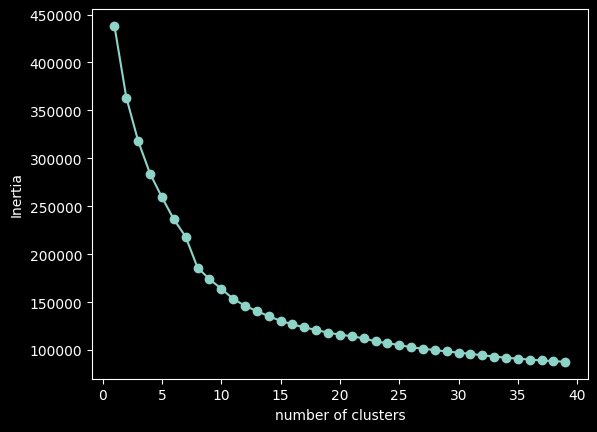

In [58]:
inertia = []
list_num_clusters = list( range(1,40) )
# Find an optimized number of neighors k from a candidate list such as list_k = list(range(1, 30))
for num_clusters in list_num_clusters:
    km=sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=rs)
    km.fit(features_pca)
    inertia.append(km.inertia_)

plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('number of clusters')
plt.ylabel('Inertia')

We will take 20 clusters

In [59]:
k=20
km = sklearn.cluster.KMeans(n_clusters=k, random_state=rs)
km.fit(features_pca)
km_labels = km.labels_
km_labels, km_labels.shape

(array([ 3,  3, 12, ...,  9,  2,  2], dtype=int32), (33901,))

In [60]:
profiles_pca.loc[:, profiles_pca.columns=='user']

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


In [61]:
def combine_cluster_labels(labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)    
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(profiles_pca.loc[:, profiles_pca.columns=='user'], 
                          labels_df, 
                          left_index=True, 
                          right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

clusters = combine_cluster_labels(km.labels_)
clusters

,user,cluster
0,2,3
1,4,3
2,5,12
3,7,2
4,8,11
...,...,...
33896,2102054,15
33897,2102356,2
33898,2102680,9
33899,2102983,2


##### **Generate course recommendations based on the popular courses in the same cluster**

The clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group.

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.

In [62]:
users_labelled = pd.merge(ratings_df,clusters, left_on='user', right_on='user')[['user', 'item', 'cluster']]
users_labelled

,user,item,cluster
0,1889878,CC0101EN,8
1,1342067,CL0101EN,11
2,1990814,ML0120ENv3,3
3,380098,BD0211EN,18
4,779563,DS0101EN,17
...,...,...,...
233301,1540125,DS0101EN,11
233302,1250651,PY0101EN,17
233303,1003832,CB0105ENv1,7
233304,922065,BD0141EN,5


We can see how many people on each cluster has taken the same course

In [63]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = users_labelled[['item', 'cluster']]
# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)
courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()
courses_cluster_grouped


,cluster,item,enrollments
0,0,AI0111EN,23
1,0,BC0101EN,870
2,0,BC0201EN,256
3,0,BC0202EN,112
4,0,BD0101EN,467
...,...,...,...
2009,19,SW0201EN,24
2010,19,TA0105,37
2011,19,TA0105EN,58
2012,19,TA0106EN,6


In [64]:
def recomend_courses_in_cluster(user_id=2):
    '''
    Function recomends 15 most popular courses, that user has not taken, in the cluster 
    the user belongs.
    
    Parameters: 
    user_id (int): User id
    Return: 
    data_frame with top five courses in user's cluster that user has not taken
    '''
    user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
    cluster_user = users_labelled[users_labelled['user']==user_id]['cluster'].iloc[0]
    ###courses in user cluster
    courses_cluster = courses_cluster_grouped[courses_cluster_grouped['cluster']==cluster_user]['item'].values
    ###courses in cluster unkwon to user
    user_unseen_courses_cluster = list(set(courses_cluster).difference(user_courses))
    ##recommendations
    rec_courses = courses_cluster_grouped[courses_cluster_grouped['item'].isin(user_unseen_courses_cluster)]
    ##top recommendations
    top_rec_user = rec_courses.sort_values(by='enrollments', ascending=False).head(15)
    return top_rec_user


##### Recommendations

In [118]:
user_id = random.choice(user_ids)

##user courses
print(f'User {user_id} has taken the following courses:')
user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
for course in user_courses:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

##recommended courses
print('--------------------')
print('Recommended Courses')
top_suggestions = recomend_courses_in_cluster(user_id=user_id)
for course in top_suggestions['item'].values:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

User 1590388 has taken the following courses:
['spark fundamentals i']
['mapreduce and yarn']
['moving data into hadoop']
['hadoop 101']
['big data 101']
--------------------
Recommended Courses
['python for data science']
['python for data science']
['introduction to data science']
['data analysis with python']
['data visualization with python']
['machine learning with python']
['build your own chatbot']
['r for data science']
['introduction to data science']
['blockchain essentials']
['introduction to data science']
['cloud native security conference   data security']
['data analysis with python']
['accessing hadoop data using hive']
['deep learning 101']


### D. Collaborative Filtering based Recommender System using Nearest Neighbors

Collaborative filtering is probably the most commonly used recommendation algorithm, there are two main types of methods: 
 - **User-based** collaborative filtering is based on the user similarity or neighborhood
 - **Item-based** collaborative filtering is based on similarity among items

They both work similarly, let's briefly explain how user-based collaborative filtering works.

User-based collaborative filtering looks for users who are similar. This is very similar to the user clustering method done previously; where we employed explicit user profiles to calculate user similarity. To determine if two users are similar we use the user-item interaction matrix.

##### **User-item interaction matrix**

For most collaborative filtering-based recommender systems, the main dataset format is a 2-D matrix called the user-item interaction matrix. In the matrix, its row is labeled as the user id/index and column labelled to be the item id/index, and the element (i, j) represents the rating of user i to item j.

Below is the user-item interaction matrix for our problem:

In [66]:
#ratings_sparse =ratings_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index()
#ratings_sparse

In [67]:
'''to save some memory we are only going to use a subset of users
with the whole data set we would work with 33901 users, so the similarity matrix for
users would be of size 33901*33901'''
ratings_sparse = ratings_df.loc[:25000].pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
ratings_sparse

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0101EN,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774,2099010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15775,2099019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15776,2100030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15777,2101535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### KNN-based collaborative filtering

As we can see from above, each row vector represents the rating history of a user and each column vector represents the users who rated the item. A user-item interaction matrix is usually very sparse, one user very likely only interacts with a very small subset of items and one item is very likely to be interacted by a small subset of users.

To determine if two users are similar, we can simply calculate the similarities between their row vectors in the interaction matrix. Then based on the similarity measurements, we can find the `k` nearest neighbors as the similar users.

Item-based collaborative filtering works similarly, we just need to look at the user-item matrix vertically. Instead of finding similar users, we are trying to find similar items (courses). If two courses are enrolled by two groups of similar users, then we could consider the two items are similar and use the known ratings from the other users to predict the unknown ratings.

If we formulate the KNN based collaborative filtering,  the predicted rating of user $u$ to item $i$, $\hat{r}_{ui}$ is given by:

**User-based** collaborative filtering:

$$\hat{r}_{ui} = \frac{
\sum\limits_{v \in N^k_i(u)} \text{similarity}(u, v) \cdot r_{vi}}
{\sum\limits_{v \in N^k_i(u)} \text{similarity}(u, v)}$$

**Item-based** collaborative filtering:
$$\hat{r}_{ui} = \frac{
\sum\limits_{j \in N^k_u(i)} \text{similarity}(i, j) \cdot r_{uj}}
{\sum\limits_{j \in N^k_u(i)} \text{similarity}(i, j)}$$

Here $N^k_i(u)$ notates the nearest k neighbors of $u$.


##### Users similarity matrix

In [68]:
sim_mat_users =sklearn.metrics.pairwise_distances(ratings_sparse.iloc[:,1:])
##normalizing
max_mat =np.max(sim_mat_users)
for i in range(sim_mat_users.shape[1]):
    sim_mat_users[i]=1-sim_mat_users[i]/max_mat

sim_mat_users = pd.DataFrame(data=sim_mat_users, 
                             columns=ratings_sparse['user'].values,
                             index=ratings_sparse['user'].values)
sim_mat_users = sim_mat_users.reset_index().rename(columns={'index':'user'})
sim_mat_users

,user,2,4,5,9,12,16,25,26,27,...,2096472,2097481,2097904,2097995,2098743,2099010,2099019,2100030,2101535,2102054
0,2,1.000000,0.408392,0.349090,0.401757,0.459532,0.521516,0.459532,0.459532,0.459532,...,0.454685,0.524273,0.438049,0.476852,0.524273,0.454685,0.438049,0.459532,0.438049,0.438049
1,4,0.408392,1.000000,0.406172,0.464424,0.529838,0.659721,0.529838,0.529838,0.529838,...,0.524273,0.648312,0.505291,0.549854,0.464424,0.576978,0.505291,0.529838,0.505291,0.505291
2,5,0.349090,0.406172,1.000000,0.469360,0.535469,0.535469,0.535469,0.535469,0.535469,...,0.529838,0.555738,0.510640,0.555738,0.469360,0.529838,0.510640,0.535469,0.510640,0.510640
3,9,0.401757,0.464424,0.469360,1.000000,0.612702,0.612702,0.612702,0.612702,0.612702,...,0.605966,0.637262,0.583246,0.637262,0.535469,0.605966,0.583246,0.612702,0.583246,0.583246
4,12,0.459532,0.529838,0.535469,0.612702,1.000000,0.709809,0.709809,0.709809,0.709809,...,0.700878,0.743505,0.671527,0.743505,0.612702,0.837779,0.671527,0.709809,0.671527,0.671527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774,2099010,0.454685,0.576978,0.529838,0.605966,0.837779,0.700878,0.700878,0.700878,0.700878,...,0.692206,0.733443,0.663611,0.733443,0.605966,1.000000,0.663611,0.700878,0.663611,0.663611
15775,2099019,0.438049,0.505291,0.510640,0.583246,0.671527,0.671527,0.671527,0.671527,0.671527,...,0.663611,0.700878,0.637262,0.700878,0.583246,0.663611,1.000000,0.671527,0.637262,0.637262
15776,2100030,0.459532,0.529838,0.535469,0.612702,0.709809,0.709809,0.709809,0.709809,0.709809,...,0.700878,0.743505,0.671527,0.743505,0.612702,0.700878,0.671527,1.000000,0.671527,0.671527
15777,2101535,0.438049,0.505291,0.510640,0.583246,0.671527,0.671527,0.671527,0.671527,0.671527,...,0.663611,0.700878,0.637262,0.897402,0.583246,0.663611,0.637262,0.671527,1.000000,0.637262


##### Predicting ratings of unknwon courses, user-based

We use the formula above. Note that each column/row of sim_mat_users is the similarity between users, so the $k$-nearest neighbors of user $i$ are the indices of the $k$ rows of column $i$ with highest similarities. We work with $k=1000$.

In [69]:
def ubased_ratings_neigbors(user_id=2, neighbors = 1000):
    '''
    Predicts the ratings of the courses the user has not taken.

    Parameters:
    user_id (int): user_id
    neighbors (int): number of neighbors to compute the predicted ratings
    Return:
    Data Frame with course_id and ratings ordered in descending orde.
    '''
    courses = []
    ratings = []
    ##courses taken and not taken
    user_courses=ratings_df.loc[:25000][ratings_df.loc[:25000]['user']==user_id]['item'].to_list()
    all_courses = ratings_df.loc[:25000]['item'].unique()
    unseen_courses = list(set(all_courses).difference(user_courses))
    ##similarities
    sim_uv =sim_mat_users[user_id].sort_values(ascending=False)[1:neighbors+1]
    ratings_neighbors = ratings_sparse.iloc[sim_uv.index][unseen_courses]
    ##we discard the courses that have not been rated by any neighbor
    for column in unseen_courses:
        if (ratings_neighbors[column]==0).all():
            ratings_neighbors.drop(column, axis=1, inplace=True)

    #predicting ratings
    for column in list(ratings_neighbors.columns):
        courses.append(column)
        ratings.append(np.dot(ratings_neighbors[column].values, sim_uv.values)/np.sum(np.dot(np.sign(ratings_neighbors[column].values), sim_uv.values)))
    #return a dataframe with course and ratings
    dict_ratings ={ 'course_id':courses, 'ratings':ratings}
    return pd.DataFrame(dict_ratings).sort_values(by='ratings', ascending=False)#, columns=['course_id', 'rating'])

ubased_ratings_neigbors(user_id=739631)         

,course_id,ratings
45,DB0151EN,4.000000
71,TA0106EN,3.501952
55,BD0221EN,3.201252
51,SC0105EN,3.125856
44,ML0101EN,3.100611
...,...,...
59,ML0111EN,3.000000
30,DA0101EN,3.000000
32,DS0301EN,3.000000
23,PY0101EN,3.000000


##### Recommendations

In [119]:
user_id = random.choice(ratings_df.loc[:25000]['user'].unique())

##user courses
print(f'User {user_id} has taken the following courses:')
user_courses = ratings_df[ratings_df['user'] == user_id]['item'].to_list()
for course in user_courses:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

##recommended courses
print('--------------------')
print('Recommended Courses')
top_suggestions = ubased_ratings_neigbors(user_id=user_id).head(15)
for course in top_suggestions['course_id'].values:
    print(course_content_df[course_content_df['COURSE_ID']==course]['TITLE'].values)

User 1883674 has taken the following courses:
['statistics 101']
['introduction to data science']
['data science hands on with open source tools']
['digital analytics   regression']
['data visualization with python']
['r for data science']
['data science methodology']
['data analysis with python']
['introduction to cloud']
['python for data science']
--------------------
Recommended Courses
['hybrid cloud conference  ai pipelines lab']
['build your own chatbots']
['text analytics 101']
['accelerating deep learning with gpus']
['data   ai  jumpstart your journey']
['watson analytics for social media']
['building cloud native and multicloud applications']
['building cloud native and multicloud applications']
['data   ai essentials']
['data visualization with r']
['cloud native security conference   data security']
['node red  basics to bots']
['modernizing java ee applications']
['scalable web applications on kubernetes']
['analyzing big data in r using apache spark']


## 6. Conclusion

In this notebook we consired a dataset containing information of online courses as well as information about users interaction with the courses. We construct different recommender systems using content-base and collaborative filtering with the objective to explore the main ideas to construct recommender systems.